In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import FloatType
import pyspark.sql.functions as f
from pyspark.sql import Row
from pyspark import StorageLevel
from pyspark.sql import SparkSession
import sys
import numpy as np
import matplotlib.pylab as plt

In [2]:
# sc = SparkContext("local[*]", "NFL")
# rdd = sc.textFile('../in/PlayerTrackData.csv')

# remove header
# rdd = rdd.filter(lambda x: 'PlayKey' not in x)

# split the col
# rdd = rdd.map(lambda x: x.split(','))

# remove row if missing some value
# rdd = rdd.filter(lambda x: x[5] != '' and x[7] != '')

# convert to dataframe object
# sqlContext = SQLContext(sc)
# df = rdd.toDF(['PlayKey','time','event','x','y','dir','dis','o','s'])

# if df want to use rdd function
# just df.rdd.xxx()

In [2]:
spark = SparkSession.builder.master("local[*]").appName("NFL").getOrCreate()
tracks = spark.read.option("header",True).csv('../in/PlayerTrackData.csv')

In [3]:
# show header
# rdd.take(1)
# show schema
tracks.printSchema()

root
 |-- PlayKey: string (nullable = true)
 |-- time: string (nullable = true)
 |-- event: string (nullable = true)
 |-- x: string (nullable = true)
 |-- y: string (nullable = true)
 |-- dir: string (nullable = true)
 |-- dis: string (nullable = true)
 |-- o: string (nullable = true)
 |-- s: string (nullable = true)



In [4]:
tracks.count()

76366748

In [5]:
# convert the defautl datatype
tracks = tracks.withColumn("time", tracks.time.cast('float').alias("time"))
tracks = tracks.withColumn("x", tracks.x.cast('float').alias("x"))
tracks = tracks.withColumn("y", tracks.y.cast('float').alias("y"))
tracks = tracks.withColumn("dir", tracks.dir.cast('float').alias("dir"))
tracks = tracks.withColumn("o", tracks.o.cast('float').alias("o"))
tracks = tracks.withColumn("s", tracks.s.cast('float').alias("s"))
tracks = tracks.withColumn("x", tracks.x.cast('float').alias("x"))

In [6]:
tracks.printSchema()

root
 |-- PlayKey: string (nullable = true)
 |-- time: float (nullable = true)
 |-- event: string (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- dir: float (nullable = true)
 |-- dis: string (nullable = true)
 |-- o: float (nullable = true)
 |-- s: float (nullable = true)



In [7]:
# get all ball_snap play record
ball_snap_tracks = tracks.where("event == 'ball_snap'")

# rename x,y,time for ball snap
drop_list = ['dir','dis','o','event','s']
ball_snap_tracks = ball_snap_tracks.withColumnRenamed('x','snap_x')\
.withColumnRenamed('y','snap_y')\
.withColumnRenamed('time','snap_time').drop(*drop_list)

# join two table (orign tracks and tracks only contained ball_snap event)
tracks = tracks.join(ball_snap_tracks, ['PlayKey'], "left_outer")

# remove any data for a play 0.1 second before snap
tracks = tracks.where('time >= (snap_time - 0.1)')


In [8]:
# get the last event of each play key
last_event_tracks = tracks.where('event is not null').groupBy('PlayKey').agg(f.max('time').alias('time'))

# join last event tracks and tracks
# only get the playkey, time, and event field
last_event_tracks = last_event_tracks.join(tracks, ['PlayKey','time'], "inner")[['PlayKey','time','event']]

# rename the column
last_event_tracks = last_event_tracks.withColumnRenamed('time','last_time').withColumnRenamed('event','last_event')

# park the result of last event tracks to the tracks
tracks = tracks.join(last_event_tracks, ['PlayKey'], 'left_outer')

# Remove any data for a play 0.1 second after last event
tracks = tracks.where('time <= (last_time + 0.1)')

In [9]:
tracks.printSchema()

root
 |-- PlayKey: string (nullable = true)
 |-- time: float (nullable = true)
 |-- event: string (nullable = true)
 |-- x: float (nullable = true)
 |-- y: float (nullable = true)
 |-- dir: float (nullable = true)
 |-- dis: string (nullable = true)
 |-- o: float (nullable = true)
 |-- s: float (nullable = true)
 |-- snap_time: float (nullable = true)
 |-- snap_x: float (nullable = true)
 |-- snap_y: float (nullable = true)
 |-- last_time: float (nullable = true)
 |-- last_event: string (nullable = true)



In [10]:
# save tracks into memory
# only record the time from the start of first event-1 to the end of last event+1
tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string]

In [10]:
pd = tracks.where('event == "ball_snap"').toPandas()

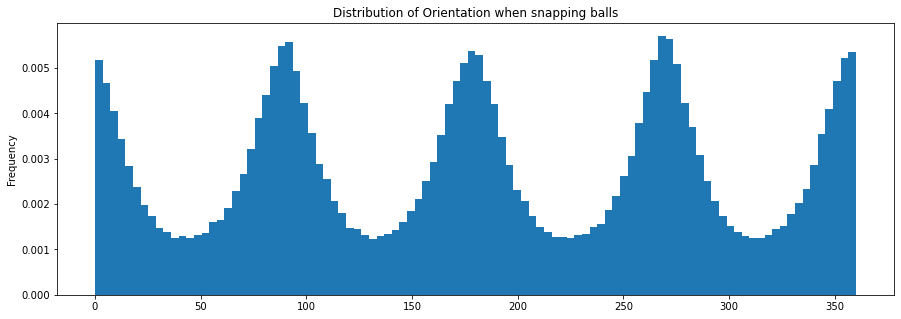

In [21]:
pd['o'].plot(kind='hist',
             bins=100,
             figsize=(15, 5),
             density=True,
             title='Distribution of Orientation when snapping balls')
plt.savefig('../out/o_hist.png')

In [11]:
#load play list data
playlist = spark.read.option("header",True).csv('../in/PlayList.csv')

# convert player day to integer
playlist = playlist.withColumn("PlayerDay", playlist.PlayerDay.cast('int').alias("PlayerDay"))

In [12]:
playlist.printSchema()

root
 |-- PlayerKey: string (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- RosterPosition: string (nullable = true)
 |-- PlayerDay: integer (nullable = true)
 |-- PlayerGame: string (nullable = true)
 |-- StadiumType: string (nullable = true)
 |-- FieldType: string (nullable = true)
 |-- Temperature: string (nullable = true)
 |-- Weather: string (nullable = true)
 |-- PlayType: string (nullable = true)
 |-- PlayerGamePlay: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- PositionGroup: string (nullable = true)



In [13]:
# get season 2 distinct player key
tough_playerkey = playlist.select('PlayerKey').where('PlayerDay >= 350').distinct()
tough_playerkey = tough_playerkey.rdd.map(lambda x:x.PlayerKey).collect()

In [14]:
# only select the player who play in season 2, dont know is he play season 1
tough_playlist = playlist[playlist.PlayerKey.isin(tough_playerkey)]

# add season to df, if less than 350, season 1 else season 2
tough_playlist = tough_playlist.withColumn('season', f.when(f.col("PlayerDay") < 350,1).otherwise(2))

In [15]:
games = tough_playlist[['GameID','season']].distinct()

In [16]:
_tracks = tracks.join(tough_playlist[['PlayKey','GameID']],['PlayKey'],'left_outer')
_tracks = _tracks.join(games,['GameID'],'left_outer')
_tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[GameID: string, PlayKey: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int]

In [17]:
# Fix orientation
# Assume other seasons based on direction at snap - if orientation at snap is outside normal range, shift.
s1 = _tracks.select('PlayKey').where('event == "ball_snap" and o < 50 and season is null').distinct().collect()
s2 = _tracks.select('PlayKey').where('event == "ball_snap" and o > 325 and season is null').distinct().collect()
s3 = _tracks.select('PlayKey').where('event == "ball_snap" and o < 225 and o > 125 and season is null').distinct().collect()

def get(x, field='PlayKey'):
    return [i[field] for i in x]

abnormal_playkey = get(s1)+get(s2)+get(s3)
abnormal_playkey = list(set(abnormal_playkey))

In [18]:
# all abnormal orientation record will be treated as session 1
tracks = _tracks.withColumn('season', 
                            f.when(_tracks.season.isNull()
                                   & _tracks.PlayKey.isin(abnormal_playkey),1).otherwise(f.col('season')))

# all normal orientation record will be treated as session 2
tracks = tracks.withColumn('season', 
                           f.when(tracks.season.isNull()
                                  & ~tracks.PlayKey.isin(abnormal_playkey),2).otherwise(f.col('season')))
# tracks.persist(StorageLevel.MEMORY_ONLY)

In [19]:
# Change orientation for season 1
clean_tracks = tracks.withColumn('o',f.when(f.col('season')== 1, (f.col('o')+90)%360).otherwise(f.col('o')))
# clean_tracks.persist(StorageLevel.MEMORY_ONLY)

In [20]:
# join clean track and playlist
tracks = clean_tracks.join(playlist[['PlayKey','PlayerKey','RosterPosition','PositionGroup','FieldType','PlayType']], ['PlayKey'], 'inner')

In [21]:
tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, GameID: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int, PlayerKey: string, RosterPosition: string, PositionGroup: string, FieldType: string, PlayType: string]

In [21]:
pd = tracks.where('event == "ball_snap"').toPandas()

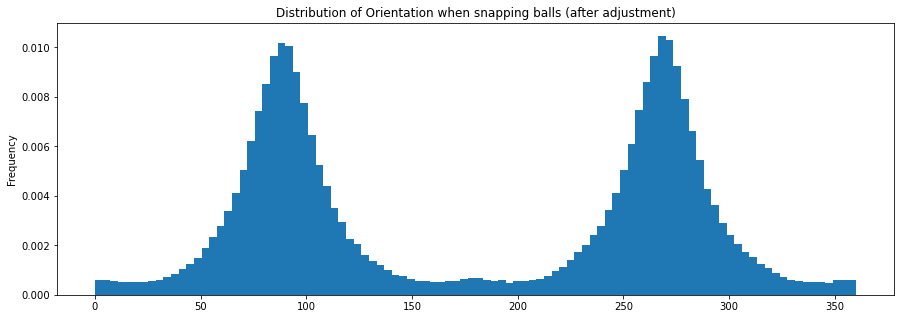

In [22]:
pd['o'].plot(kind='hist',
             bins=100,
             figsize=(15, 5),
             density=True,
             title='Distribution of Orientation when snapping balls (after adjustment)')
plt.savefig('../out/adjust_o_hist.png')

In [22]:
#load injury data
injury = spark.read.option("header",True).csv('../in/InjuryRecord.csv')

injury_plays = injury.select('PlayKey').distinct().collect()
injury_plays = get(injury_plays)

injury_players = injury.select('PlayerKey').distinct().collect()
injury_players = get(injury_players, field='PlayerKey')

In [89]:
injury_playlist = injury.join(playlist, ['PlayKey'],'inner')

In [90]:
res = injury_playlist.select(['playType','PlayKey']).distinct().groupby(['playType']).count()
res.collect()

[Row(playType='Kickoff', count=7),
 Row(playType='Kickoff Not Returned', count=1),
 Row(playType='Punt Not Returned', count=1),
 Row(playType='Punt Returned', count=3),
 Row(playType='Rush', count=23),
 Row(playType='Kickoff Returned', count=1),
 Row(playType='Punt', count=9),
 Row(playType='Pass', count=31)]

In [81]:
injury_playlist.select(['RosterPosition','GameID']).distinct().groupby(['RosterPosition']).count().collect()

[Row(RosterPosition='Linebacker', count=23),
 Row(RosterPosition='Defensive Lineman', count=9),
 Row(RosterPosition='Offensive Lineman', count=7),
 Row(RosterPosition='Running Back', count=9),
 Row(RosterPosition='Safety', count=15),
 Row(RosterPosition='Wide Receiver', count=23),
 Row(RosterPosition='Cornerback', count=12),
 Row(RosterPosition='Tight End', count=6)]

In [23]:
# only focus on 4 kind of position
tracks = tracks.withColumn('is_main_pos', 
                           f.when(tracks.RosterPosition.isin(['Linebacker','Safety','Wide Receiver','Cornerback']),True).otherwise(False))

# is player get injuryed in the play
tracks = tracks.withColumn('is_injury_play', 
                           f.when(tracks.PlayKey.isin(injury_plays),True).otherwise(False))

# is player rush or pass
tracks = tracks.withColumn('is_rush_pass', 
                           f.when(tracks.PlayType.isin(['Rush','Pass']),True).otherwise(False))


In [24]:
# Time since the snap (only remain the record that with in 25 seconds start at snapping a ball)
tracks = tracks.withColumn('time_since_snap',tracks.time-tracks.snap_time)
tracks = tracks.where('time_since_snap <= 25')

In [25]:
tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, GameID: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int, PlayerKey: string, RosterPosition: string, PositionGroup: string, FieldType: string, PlayType: string, is_main_pos: boolean, is_injury_play: boolean, is_rush_pass: boolean, time_since_snap: float]

In [26]:
_tracks = tracks.withColumn('o_dir_diff1', f.abs(tracks.o-tracks.dir))
_tracks = _tracks.withColumn('o_dir_diff2', f.abs(_tracks.o-(_tracks.dir-360)))
_tracks = _tracks.withColumn('o_dir_diff3', f.abs(_tracks.o-(_tracks.dir+360)))
_tracks = _tracks.withColumn('o_dir_diff', f.least(_tracks.o_dir_diff1,_tracks.o_dir_diff2,_tracks.o_dir_diff3))

drop = ['o_dir_diff1', 'o_dir_diff2', 'o_dir_diff3']
_tracks = _tracks.drop(*drop)

In [27]:
# class the movement
_tracks = _tracks.withColumn('movement', 
                           f.when(f.col('o_dir_diff') >= 45, 'abnormal')\
                           .otherwise('normal'))

In [28]:
# label is abnormal movement
_tracks = _tracks.withColumn('is_abnormal_movement', 
                           f.when(f.col('movement') == 'normal', False)\
                           .otherwise(True))

_tracks.persist(StorageLevel.MEMORY_ONLY)

DataFrame[PlayKey: string, GameID: string, time: float, event: string, x: float, y: float, dir: float, dis: string, o: float, s: float, snap_time: float, snap_x: float, snap_y: float, last_time: float, last_event: string, season: int, PlayerKey: string, RosterPosition: string, PositionGroup: string, FieldType: string, PlayType: string, is_main_pos: boolean, is_injury_play: boolean, is_rush_pass: boolean, time_since_snap: float, o_dir_diff: float, movement: string, is_abnormal_movement: boolean]

In [30]:
# show the ratio between movement and injury (RosterPosition)
t_group = _tracks.where('is_rush_pass == True and is_main_pos == True').groupby(['movement','is_injury_play']).count()
t_group.show()

+--------+--------------+-------+
|movement|is_injury_play|  count|
+--------+--------------+-------+
|abnormal|          true|   1225|
|  normal|         false|4693708|
|  normal|          true|   1102|
|abnormal|         false|3655407|
+--------+--------------+-------+



In [58]:
# show the ratio between speed and injury
t_group = _tracks.select(['s','is_jury_play']).groupby('is_jury_play').agg(f.mean("s").alias('avg_speed'))
t_group.show()


+------------+-----------------+
|isInjuryPlay|        avg_speed|
+------------+-----------------+
|        true| 3.10926030685172|
|       false|2.653949671597476|
+------------+-----------------+



In [127]:
# show the ratio between movement and injury (no isInjuryPronePos)
t_group = _tracks.where('is_rush_pass == True').groupby(['movement','is_injury_play']).count()
t_group.show()

+--------+------------+-------+
|movement|isInjuryPlay|  count|
+--------+------------+-------+
|abnormal|        true|   1739|
|  normal|       false|7677686|
|  normal|        true|   1698|
|abnormal|       false|6522190|
+--------+------------+-------+



In [65]:
_tracks.count()

15958159

In [6]:
p = playlist.toPandas()

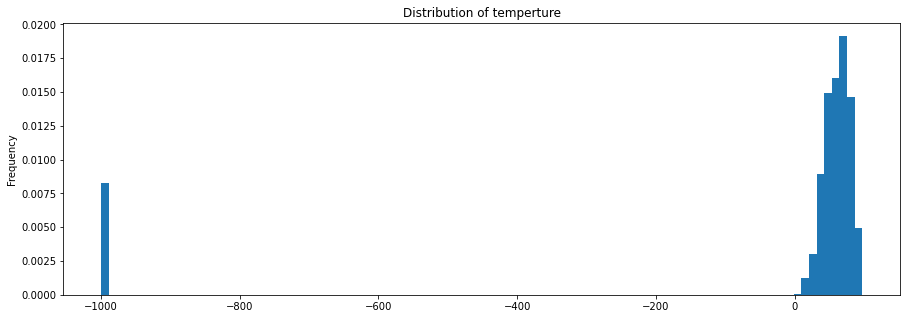

In [7]:
p['Temperature'].astype('int32').plot(kind='hist',
             bins=100,
             figsize=(15, 5),
             density=True,
             title='Distribution of temperture')
plt.savefig('../out/temperture.png')

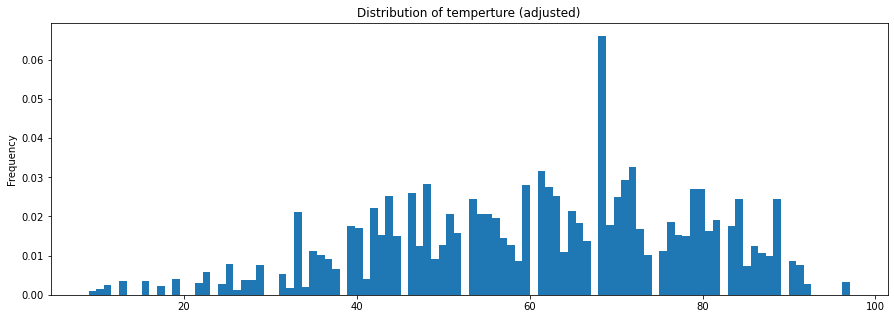

In [21]:
res = p[p['Temperature'].astype('int32') > -999]['Temperature'].dropna().replace('-999', '60').astype('int32').plot(kind='hist',
             bins=100,
             figsize=(15, 5),
             density=True,
             title='Distribution of temperture (adjusted)')
plt.savefig('../out/adjust_temperture.png')